In [1]:
import re
import json

def compile(source, defines=""):
    if defines != "":
        !bash -lc "cd .. && rm build/{source}.bench"
    !bash -lc "cd .. && make -s build/{source}.bench EXTRA_CXXFLAGS='{defines}'"
    
def bench(source, n, defines="", t=2**25, l=64):
    compile(source, defines)
    res = !./../build/{source}.bench {n} {t} {l}
    # print(res)
    return float(str(res).split()[1])

def perf(source, n, t):

    PERF_EVENTS = {
        "cycles",
        "instructions",
        "L1-dcache-loads",
        "L1-dcache-load-misses",
        "LLC-loads",
        "LLC-load-misses",
        "cache-references",
        "cache-misses",
    }
    
    compile(source)
    lines = !bash -lc "taskset -c 8 perf stat -r 10 -e cycles,instructions,L1-dcache-loads,L1-dcache-load-misses,LLC-loads,LLC-load-misses,cache-references,cache-misses ./../build/{source}.bench {n} {t}"
    
    data = {}
    for line in lines:
        line = line.split("#", 1)[0]
        m = re.match(r"\s*([\d,]+)\s+([\w\-]+)", line)
        if not m:
            continue

        value = int(m.group(1).replace(",", ""))
        event = m.group(2)

        if event in PERF_EVENTS:
            data[event] = value
    
    return data

In [2]:
perf("matmul12_avx512", 1024, t=2**30)

{'cycles': 1667961585,
 'instructions': 4645685836,
 'L1-dcache-loads': 1953144870,
 'L1-dcache-load-misses': 484492753,
 'cache-references': 1225806010,
 'cache-misses': 4646713}

In [3]:
bench("matmul12_avx512", 1024, t=2**30)

162079991.0

In [4]:
ns = [i for i in range(8, 1024+1, 8)]

In [5]:
names = {
    'matmul1_ikj': 'naive',
    'matmul6_restrict': 'restrict',
    'matmul7_transpose': 'transpose',
    'matmul8_L1_tiles': 'L1_tiles',
    'matmul9_L2_tiles': 'L2_tiles',
    'matmul10_sse': 'sse',
    'matmul11_avx': 'avx',
    'matmul12_avx512': 'avx512',
    'matmul14_kernel': 'kernel', 
}

# results = {name: [bench(source, n) for n in ns] for source, name in names.items()}

# print(results)

In [6]:
import matplotlib.pyplot as plt

    
def plot(results, ns, subset):

    def gflops(l):
        return [n**3 / t / 10**9 for t, n in zip(l, ns)]
    
    plt.figure(figsize=(10,6))
    for label in subset:
        plt.plot(ns, gflops(results[label]), marker='o', linewidth=1, markersize=3, label=label)

    plt.xlabel('n')
    plt.ylabel('GFLOPS')
    plt.ylim(bottom=0)
    plt.margins(0)

    plt.legend()
    
    plt.show()

    
# plot(results, ns, [
# 'naive', 'restrict', 'transpose', 'L1_tiles', 'L2_tiles', 'sse', 'avx', 'avx512', 'kernel'
# ])

In [7]:
def find_opt_kernel():
    results = {}
    names = []
    ns = [n for n in range(255, 513, 25)]
    for rows in range(1, 17):
        for cols in range(1, 5):
            print("rows:", rows, "cols:", cols)
            name = f"{rows} {cols}"
            result = [bench("matmul14_kernel", n, defines=f"-DROWS_KER={rows} -DCOLS_KER={cols*16}") for n in ns]
            print(result)
            results[name] = result
            names.append(name)
    print(results, name)
    plot(results, ns, names)

rows: 1 cols: 1
[3051091.0, 3806166.0, 5049216.0, 6218011.0, 8213815.0, 10096496.0, 12168696.0, 14383479.0, 17372869.0, 19578939.0, 35394570.0]
rows: 1 cols: 2
[1705787.0, 2333058.0, 2923296.0, 4115774.0, 4880866.0, 5665625.0, 6773768.0, 8093166.0, 9429210.0, 11633207.0, 21161836.0]
rows: 1 cols: 3
[1835271.0, 2151141.0, 3066725.0, 3921795.0, 4933908.0, 5668653.0, 7235728.0, 7551671.0, 11185766.0, 10874883.0, 14984075.0]
rows: 2 cols: 1
[1540087.0, 2071459.0, 2683312.0, 3309018.0, 4220660.0, 5428170.0, 6069413.0, 7484716.0, 8852685.0, 10025215.0, 15323563.0]
rows: 2 cols: 2
[948282.0, 1253817.0, 1613107.0, 2066211.0, 2566640.0, 3024698.0, 3902843.0, 4576558.0, 5427393.0, 6069215.0, 9901774.0]
rows: 2 cols: 3
[1033135.0, 1231935.0, 1703630.0, 1956904.0, 2690376.0, 2949674.0, 3801121.0, 4274638.0, 5484125.0, 5953868.0, 7834410.0]
rows: 3 cols: 1
[1123468.0, 1485234.0, 1991238.0, 2384831.0, 3171476.0, 3647938.0, 4855759.0, 5467755.0, 6244083.0, 7215333.0, 10578421.0]
rows: 3 cols: 2
[8298

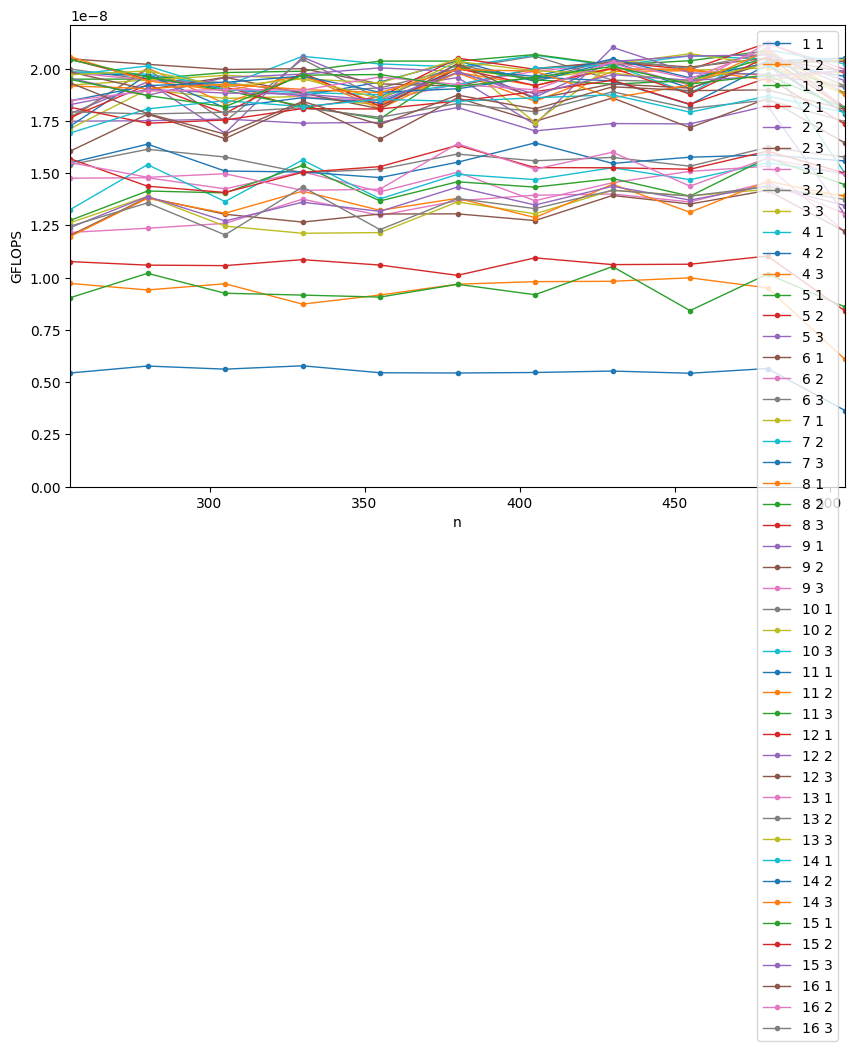

In [8]:
#find_opt_kernel()

In [12]:
def plot_flops(sources, ns):
    results = {}
    for source in sources:
        results[source] = [bench(source, n) for n in ns]
    plot(results, ns, sources)

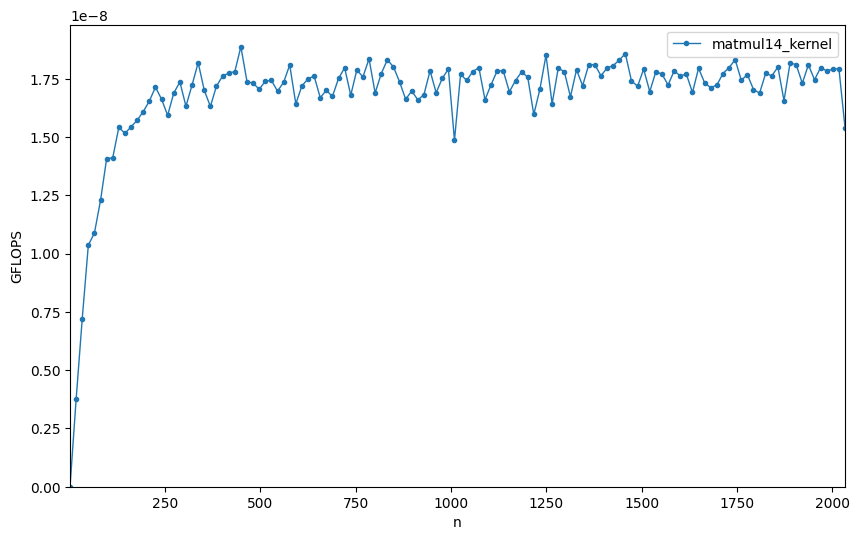

In [13]:
plot_flops(["matmul14_kernel", "matmul15_kernel_cache"], [n for n in range(1, 2**12+1, 16)])
# plot_flops(["matmul15_kernel_cache"], [n for n in range(1, 2**12+1, 16)])

In [14]:

ns = [n for n in range(255, 513, 25)]


results = {'1 1': [3051091.0, 3806166.0, 5049216.0, 6218011.0, 8213815.0, 10096496.0, 12168696.0, 14383479.0, 17372869.0, 19578939.0, 35394570.0], '1 2': [1705787.0, 2333058.0, 2923296.0, 4115774.0, 4880866.0, 5665625.0, 6773768.0, 8093166.0, 9429210.0, 11633207.0, 21161836.0], '1 3': [1835271.0, 2151141.0, 3066725.0, 3921795.0, 4933908.0, 5668653.0, 7235728.0, 7551671.0, 11185766.0, 10874883.0, 14984075.0], '2 1': [1540087.0, 2071459.0, 2683312.0, 3309018.0, 4220660.0, 5428170.0, 6069413.0, 7484716.0, 8852685.0, 10025215.0, 15323563.0], '2 2': [948282.0, 1253817.0, 1613107.0, 2066211.0, 2566640.0, 3024698.0, 3902843.0, 4576558.0, 5427393.0, 6069215.0, 9901774.0], '2 3': [1033135.0, 1231935.0, 1703630.0, 1956904.0, 2690376.0, 2949674.0, 3801121.0, 4274638.0, 5484125.0, 5953868.0, 7834410.0], '3 1': [1123468.0, 1485234.0, 1991238.0, 2384831.0, 3171476.0, 3647938.0, 4855759.0, 5467755.0, 6244083.0, 7215333.0, 10578421.0], '3 2': [829882.0, 1127352.0, 1466946.0, 1904966.0, 2344764.0, 2743118.0, 3224974.0, 4087966.0, 4867345.0, 5456824.0, 7201688.0], '3 3': [968358.0, 1155180.0, 1527302.0, 1924825.0, 2450936.0, 2746306.0, 3402428.0, 3977611.0, 4727051.0, 5523329.0, 6728539.0], '4 1': [834977.0, 1112423.0, 1480322.0, 1745307.0, 2211911.0, 2732672.0, 3217457.0, 3948945.0, 4569158.0, 5406583.0, 8593667.0], '4 2': [837406.0, 1116607.0, 1491651.0, 1921641.0, 2310907.0, 2693936.0, 3425945.0, 3911949.0, 4942682.0, 5432636.0, 6282292.0], '4 3': [943137.0, 1095530.0, 1548242.0, 1823639.0, 2445323.0, 2771858.0, 3602816.0, 4002110.0, 4733373.0, 5619357.0, 6484528.0], '5 1': [850523.0, 1125606.0, 1432033.0, 1807859.0, 2197176.0, 2694944.0, 3212865.0, 3940731.0, 4621712.0, 5302756.0, 7100900.0], '5 2': [810613.0, 1126660.0, 1483884.0, 1981620.0, 2398586.0, 2676043.0, 3326859.0, 3913708.0, 4720086.0, 5208966.0, 6510730.0], '5 3': [929135.0, 1133676.0, 1678087.0, 1748389.0, 2353881.0, 2803244.0, 3834175.0, 3782321.0, 4758122.0, 5603999.0, 6740253.0], '6 1': [809954.0, 1086301.0, 1421465.0, 1796849.0, 2321223.0, 2864127.0, 3319943.0, 3911332.0, 4691920.0, 5394019.0, 6488468.0], '6 2': [837158.0, 1128322.0, 1476917.0, 1927635.0, 2422612.0, 2848963.0, 3343297.0, 3926366.0, 4904498.0, 5213205.0, 6450790.0], '6 3': [938931.0, 1099231.0, 1623157.0, 1757438.0, 2411708.0, 2719139.0, 3409906.0, 3892869.0, 4707927.0, 5332895.0, 6717521.0], '7 1': [862980.0, 1128325.0, 1441838.0, 1840737.0, 2316570.0, 2684644.0, 3813824.0, 3930506.0, 4547564.0, 5482407.0, 6302994.0], '7 2': [841724.0, 1090616.0, 1494278.0, 1905531.0, 2385405.0, 2854375.0, 3317854.0, 3940879.0, 5005746.0, 5290287.0, 6366128.0], '7 3': [961513.0, 1113740.0, 1565225.0, 1930858.0, 2435967.0, 2746328.0, 3384468.0, 3884577.0, 4815809.0, 5457923.0, 6560988.0], '8 1': [805913.0, 1130411.0, 1498399.0, 1826077.0, 2473955.0, 2768007.0, 3461254.0, 3978956.0, 4715243.0, 5685982.0, 6469722.0], '8 2': [811461.0, 1119983.0, 1496792.0, 1974225.0, 2542857.0, 2734300.0, 3413387.0, 4128271.0, 4846689.0, 5384135.0, 6837586.0], '8 3': [938731.0, 1141936.0, 1588601.0, 1815055.0, 2458685.0, 2742258.0, 3461384.0, 3970228.0, 5015192.0, 5375535.0, 7119474.0], '9 1': [848562.0, 1172402.0, 1449523.0, 1820601.0, 2232728.0, 2762292.0, 3565361.0, 3908874.0, 4571013.0, 5354551.0, 6629950.0], '9 2': [835651.0, 1155182.0, 1448469.0, 1908290.0, 2475306.0, 2709636.0, 3581671.0, 4125965.0, 4940182.0, 5448435.0, 6327161.0], '9 3': [1363258.0, 1775706.0, 2252612.0, 2612636.0, 3447442.0, 4011709.0, 4763746.0, 5678933.0, 6915049.0, 7596715.0, 9860260.0], '10 1': [924433.0, 1231154.0, 1583735.0, 1982415.0, 2531279.0, 2993334.0, 3702872.0, 4208367.0, 5205345.0, 5977184.0, 7373486.0], '10 2': [841349.0, 1103695.0, 1482491.0, 1841615.0, 2409298.0, 2696837.0, 3339950.0, 4019409.0, 4852001.0, 5468236.0, 6862154.0], '10 3': [1251443.0, 1424926.0, 2079910.0, 2299738.0, 3249697.0, 3672132.0, 4522002.0, 5209970.0, 6414012.0, 7138588.0, 8595341.0], '11 1': [898136.0, 1144195.0, 1466814.0, 1829119.0, 2371074.0, 2882226.0, 3390370.0, 4095600.0, 5152361.0, 5480499.0, 7214534.0], '11 2': [864829.0, 1152669.0, 1473627.0, 1890877.0, 2372931.0, 2748836.0, 3341972.0, 4273343.0, 4902744.0, 5303062.0, 6853503.0], '11 3': [1301949.0, 1552011.0, 2018810.0, 2338410.0, 3273168.0, 3761823.0, 4635781.0, 5393707.0, 6777017.0, 7028498.0, 8916214.0], '12 1': [913264.0, 1262604.0, 1617320.0, 1986596.0, 2475898.0, 2973962.0, 3514904.0, 4088747.0, 5148820.0, 5654630.0, 7429667.0], '12 2': [907266.0, 1154895.0, 1506677.0, 1912843.0, 2419980.0, 2768497.0, 3536046.0, 4033325.0, 4844976.0, 5633824.0, 6469740.0], '12 3': [1380025.0, 1586986.0, 2177154.0, 2839168.0, 3429930.0, 4204505.0, 5218385.0, 5707423.0, 6966612.0, 7802324.0, 10547174.0], '13 1': [897974.0, 1159727.0, 1493312.0, 1894429.0, 2282412.0, 2851119.0, 3498151.0, 3910049.0, 4828019.0, 5267780.0, 7110742.0], '13 2': [1076237.0, 1360135.0, 1798964.0, 2392282.0, 2946082.0, 3448315.0, 4260661.0, 5047266.0, 6143554.0, 6812574.0, 8166633.0], '13 3': [1313640.0, 1580787.0, 2276184.0, 2964622.0, 3680661.0, 4028034.0, 5088510.0, 5606826.0, 6771400.0, 7776350.0, 9243997.0], '14 1': [980115.0, 1214605.0, 1536225.0, 1976403.0, 2414087.0, 2976703.0, 3570056.0, 4240816.0, 5256950.0, 5919452.0, 7192571.0], '14 2': [1070199.0, 1339728.0, 1878924.0, 2387300.0, 3025537.0, 3535258.0, 4038994.0, 5140865.0, 5975920.0, 6967174.0, 8264979.0], '14 3': [1385773.0, 1591424.0, 2168947.0, 2542030.0, 3384527.0, 3977389.0, 5160126.0, 5496012.0, 7175588.0, 7567862.0, 9277306.0], '15 1': [850898.0, 1173068.0, 1560723.0, 1825183.0, 2268725.0, 2866890.0, 3391095.0, 3954639.0, 4889032.0, 5617562.0, 7110054.0], '15 2': [1056724.0, 1527192.0, 2015911.0, 2389456.0, 2921699.0, 3360326.0, 4351732.0, 5211731.0, 6202582.0, 6890015.0, 8584583.0], '15 3': [1338229.0, 1581394.0, 2232023.0, 2640881.0, 3397089.0, 3828337.0, 4930034.0, 5533044.0, 6870486.0, 7679787.0, 9575600.0], '16 1': [858167.0, 1229997.0, 1682237.0, 1949726.0, 2582649.0, 2929112.0, 3675451.0, 4155742.0, 4971109.0, 5825607.0, 7133371.0], '16 2': [1069141.0, 1483293.0, 1895064.0, 2535351.0, 3143305.0, 3344114.0, 4373451.0, 4968720.0, 6551288.0, 7036194.0, 8614932.0], '16 3': [1330851.0, 1617004.0, 2355423.0, 2505754.0, 3638210.0, 3979638.0, 4993594.0, 5607733.0, 6775366.0, 7705916.0, 9375976.0]}

def gflops(l):
    return [n**3 / t / 10**9 for t, n in zip(l, ns)]

best_value = [-1 for n in ns]
best_candidate = ['?' for n in ns]

for label, result in results.items():
    gf = gflops(result)
    for i in range(len(ns)):
        if best_value[i] < gf[i]:
            best_value[i] = gf[i]
            best_candidate[i] = label

print(ns)
print(best_value)
print(best_candidate)

[255, 280, 305, 330, 355, 380, 405, 430, 455, 480, 505]
[2.057464639483418e-08, 2.020802705695751e-08, 1.996012916251895e-08, 2.0590646803112577e-08, 2.036198966309481e-08, 2.0504902200749392e-08, 2.0676288919702506e-08, 2.1020690734604495e-08, 2.0713589737274726e-08, 2.1231085017640736e-08, 2.0500101714469813e-08]
['8 1', '6 1', '6 1', '4 1', '5 1', '5 2', '5 1', '5 3', '7 1', '5 2', '4 2']
